In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime
import pandas as pd
from utilities.Path_Join import p_join
from dateutil.relativedelta import relativedelta
from Traitement_image.Preprocessing_for_cropped import preproc_and_crop

In [4]:
class FCM:
    def __init__(self, image, image_bit, n_clusters, m, epsilon, max_iter):
        """Modified Fuzzy C-means clustering
        <image>: 2D array, grey scale image.
        <n_clusters>: int, number of clusters/segments to create.
        <m>: float > 1, fuzziness parameter. A large <m> results in smaller
             membership values and fuzzier clusters. Commonly set to 2.
        <max_iter>: int, max number of iterations.
        """

        # -------------------Check inputs-------------------

        if np.ndim(image) != 2:
            raise Exception("<image> needs to be 2D (gray scale image).")
        if n_clusters <= 0 or n_clusters != int(n_clusters):
            raise Exception("<n_clusters> needs to be a positive integer.")
        if m < 1:
            raise Exception("<m> needs to be > 1.")
        if epsilon <= 0:
            raise Exception("<epsilon> needs to be > 0")

        self.result_def = None
        self.c = None
        self.u = None
        self.image = image
        self.image_bit = image_bit
        self.n_clusters = n_clusters  # number of clusters/segments to create
        self.m = m  # fuzziness parameter
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.shape = image.shape  # image shape
        self.X = image.flatten().astype('float')  # shape: (number of pixels)
        self.numPixels = image.size

    # ---------------------------------------------
    def initial_u(self):
        # each jth cluster (column) contains the cluster membership of the ith data point (ith row)
        # the sum of the memberships for each data point is equal to one.

        u = np.zeros((self.numPixels, self.n_clusters))
        idx = np.arange(self.numPixels)
        for ii in range(self.n_clusters):
            idxii = idx % self.n_clusters == ii
            u[idxii, ii] = 1
        return u

    def update_u(self):
        """Compute weights (cluster memberships)"""
        c_mesh, idx_mesh = np.meshgrid(self.c, self.X)  # self.c centroids of the clusters
        power = 2. / (self.m - 1)  # self.c defined in form_clusters()
        a = abs(idx_mesh - c_mesh) ** power
        b = np.sum((1. / abs(idx_mesh - c_mesh)) ** power, axis=1)

        return 1. / (a * b[:, None])

    def update_c(self):
        """Compute centroid of clusters"""  # vectorization in python to speed up the computing time
        numerator = np.dot(self.X, self.u ** self.m)
        denominator = np.sum(self.u ** self.m, axis=0)
        return numerator / denominator  # returns a matrix of shape (1,num_centroids)

    def form_clusters(self):
        """Iterative training"""
        d = 100
        self.u = self.initial_u()  # initializing the weights
        if self.max_iter != -1:
            i = 0
            self.iterate(i, True)
        else:
            i = 0
            self.iterate(i, d > self.epsilon)
        self.segmentimage()

    def iterate(self, i, condition):
        cnt = 0
        start_dt1 = datetime.datetime.now()
        while condition:
            start_dt = datetime.datetime.now()
            cnt += 1
            self.c = self.update_c()  # compute the centroids of the clusters
            old_u = np.copy(self.u)
            self.u = self.update_u()
            d = np.sum(abs(self.u - old_u))
            end_dt = datetime.datetime.now()
            diff = relativedelta(end_dt, start_dt)
            print("iter: %s, time interval: %s:%s:%s:%s" % (
                cnt, diff.hours, diff.minutes, diff.seconds, diff.microseconds))
            print("Iteration %d : cost = %f" % (i, d))

            if d < self.epsilon or i > self.max_iter:
                print('Converge at iteration {}'.format(cnt))
                end_dt1 = datetime.datetime.now()
                diff = relativedelta(end_dt1, start_dt1)
                print("duration time: %s:%s:%s:%s" % (diff.hours, diff.minutes, diff.seconds, diff.microseconds))
                break
            i += 1

    def defuzzify(self):
        return np.argmax(self.u, axis=1)  # Returns the indices of the maximum values along an axis.
        # returns the max membership value of each data point

    def segmentimage(self):
        """Segment image based on max weights"""

        result_def = self.defuzzify()
        self.result_def = result_def.reshape(self.shape).astype('int')

        return self.result_def

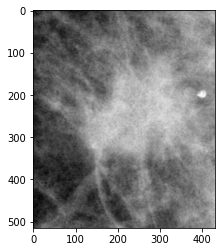

In [5]:
df = pd.read_excel(r"C:\Users\Asus\Desktop\PCD\Organized dataset\metadata\metadata_good2.0.xlsx")
parent_dir = r'C:\Users\Asus\Desktop\PCD\Organized dataset\curated'
image = mpimg.imread(p_join(parent_dir, df['image full mammo path'][0]))
center = eval(df['center of roi'][0])
shape = eval(df['Shape of cropped image'][0])
crop = preproc_and_crop(image, center, shape)
plt.imshow(crop, cmap='gray')

In [5]:
            #--------------Clustering------------
cluster = FCM(crop, image_bit=8, n_clusters=2, m=2, epsilon=0.0001, max_iter=1000)
cluster.form_clusters()
result = cluster.result_def


iter: 1, time interval: 0:0:0:370642
Iteration 0 : cost = 221962.861810
iter: 2, time interval: 0:0:0:71033
Iteration 1 : cost = 692.139165
iter: 3, time interval: 0:0:0:75219
Iteration 2 : cost = 2632.495845
iter: 4, time interval: 0:0:0:82564
Iteration 3 : cost = 7675.942807
iter: 5, time interval: 0:0:0:70506
Iteration 4 : cost = 22662.653386
iter: 6, time interval: 0:0:0:55851
Iteration 5 : cost = 52039.366706
iter: 7, time interval: 0:0:0:61326
Iteration 6 : cost = 77941.149690
iter: 8, time interval: 0:0:0:75171
Iteration 7 : cost = 55557.214941
iter: 9, time interval: 0:0:0:65713
Iteration 8 : cost = 19805.241724
iter: 10, time interval: 0:0:0:59873
Iteration 9 : cost = 4788.794938
iter: 11, time interval: 0:0:0:52867
Iteration 10 : cost = 1039.611533
iter: 12, time interval: 0:0:0:61355
Iteration 11 : cost = 305.958594
iter: 13, time interval: 0:0:0:64390
Iteration 12 : cost = 148.340949
iter: 14, time interval: 0:0:0:79132
Iteration 13 : cost = 86.223498
iter: 15, time interva

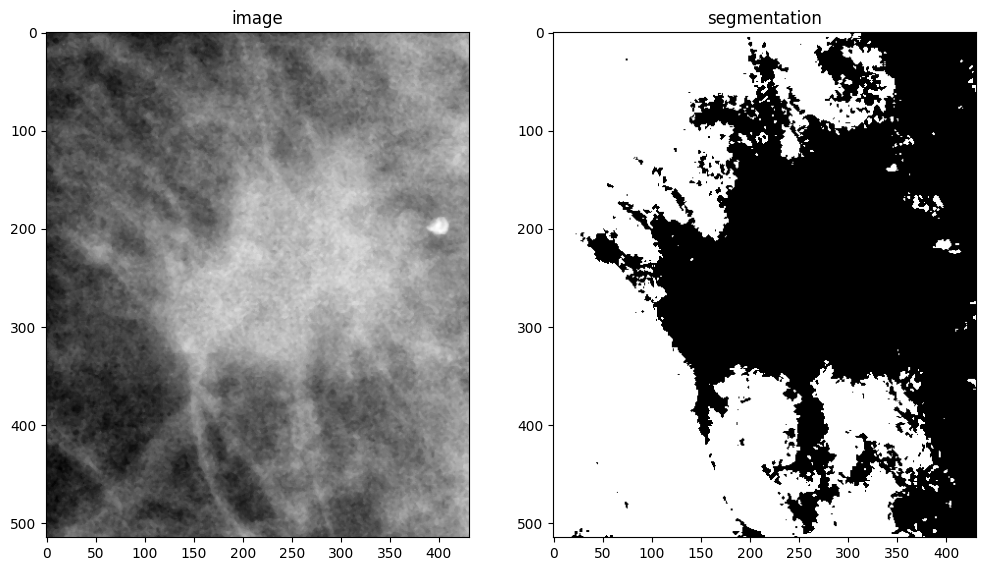

In [6]:
fig = plt.figure(figsize=(12, 8), dpi=100)

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(crop, cmap='gray')
ax1.set_title('image')

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(result, cmap='gray')
ax2.set_title('segmentation')

plt.show(block=False)
plt.close()

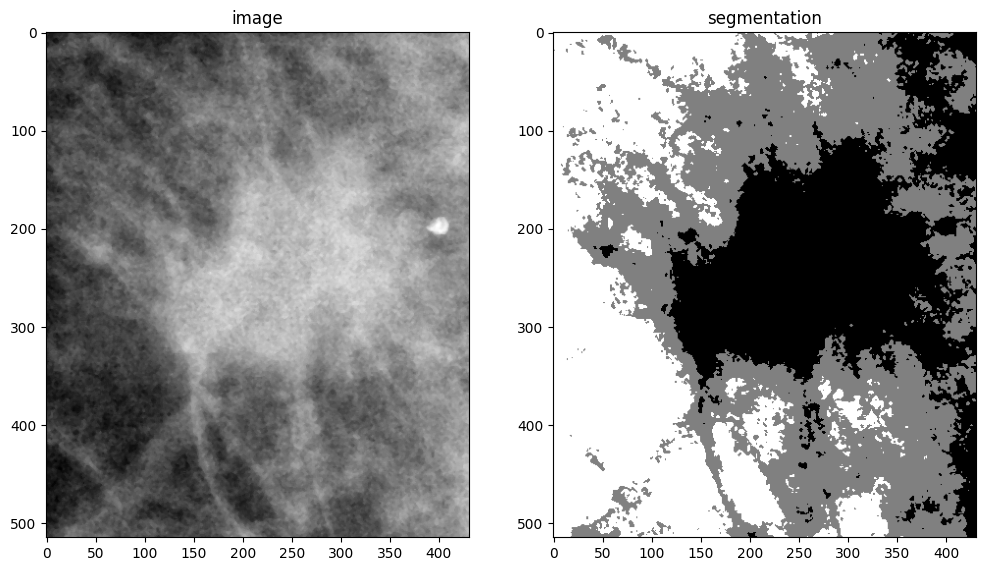

In [24]:
fig = plt.figure(figsize=(12, 8), dpi=100)

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(crop, cmap='gray')
ax1.set_title('image')

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(result, cmap='gray')
ax2.set_title('segmentation')

plt.show(block=False)
plt.close()

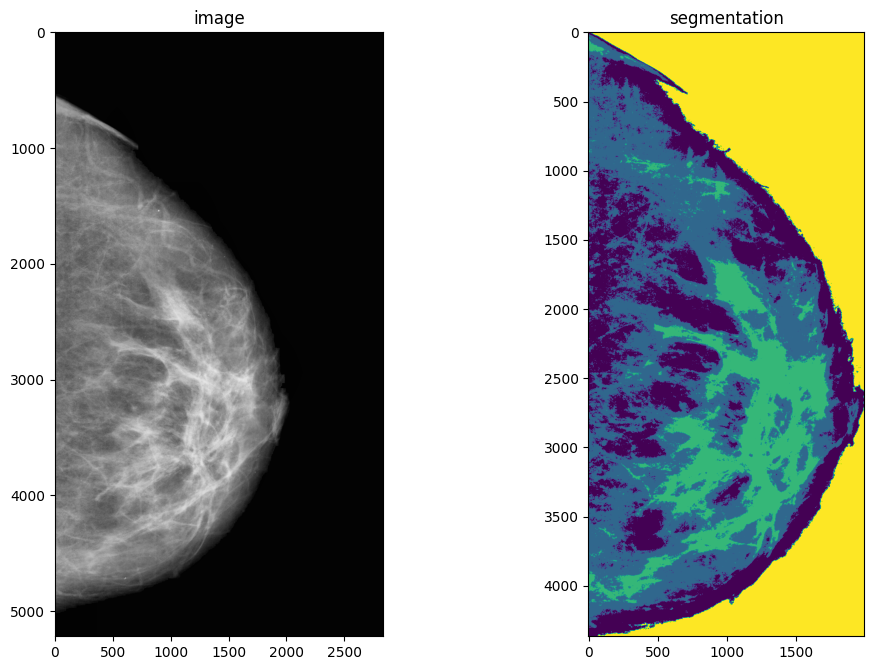

In [9]:
fig = plt.figure(figsize=(12, 8), dpi=100)

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(image, cmap='gray')
ax1.set_title('image')

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(result)
ax2.set_title('segmentation')

plt.show(block=False)
plt.close()

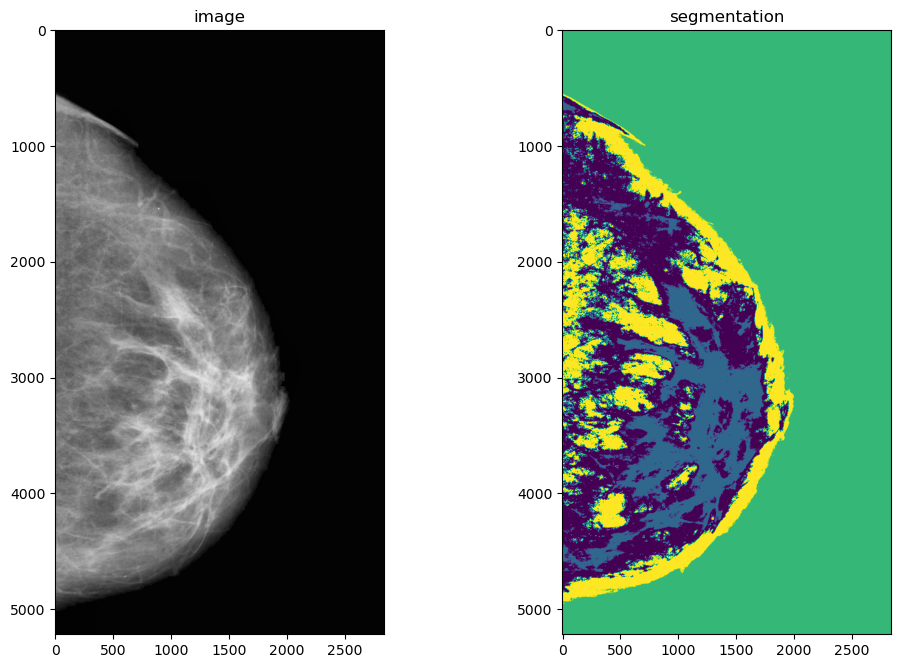

In [8]:
fig = plt.figure(figsize=(12, 8), dpi=100)

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(image, cmap='gray')
ax1.set_title('image')

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(result)
ax2.set_title('segmentation')

plt.show(block=False)
plt.close()

In [9]:
plt.imsave(r'C:\Users\Asus\Desktop\PCD\result_FCM_clusters.jpg', result)

In [7]:
for a in [result]:
    print("Shape:", a.shape)
    print("Dimensions:", a.ndim)
    print("Type:", type(a))
    print("Data type:", a.dtype)
    print(f"min value, max value: {a.min(), a.max()}")
    print("---")

Shape: (4567, 2873)
Dimensions: 2
Type: <class 'numpy.ndarray'>
Data type: int32
min value, max value: (0, 3)
---


In [6]:
def iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    print('IoU is % s' % iou_score)
    return iou_score

In [7]:
def dice_coef(img, img2):
        if img.shape != img2.shape:
            raise ValueError("Shape mismatch: img and img2 must have to be of the same shape.")
        else:

            lenIntersection=0
            for i in range(img.shape[0]):
                for j in range(img.shape[1]):
                    if ( np.array_equal(img[i][j],img2[i][j]) ):
                        lenIntersection+=1

            lenimg=img.shape[0]*img.shape[1]
            lenimg2=img2.shape[0]*img2.shape[1]
            value = (2. * lenIntersection  / (lenimg + lenimg2))
            print('Dice coefficient is % s' % value)
        return value

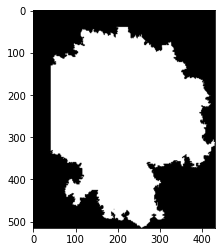

In [8]:
from Traitement_image.Restore_image import restore_mask
from Traitement_image.Crop_From_Center import crop_image_from_center
import cv2
mask_path_gr = r"C:\Users\Asus\Desktop\PCD\Organized dataset\curated\P_00001\LEFT_CC\abnormality_0\GT_mask.jpg"
gt = mpimg.imread(mask_path_gr)
res = r"C:\Users\Asus\PycharmProjects\pythonProject1\temp\FCM_cluster_2_sample_0_inv.jpg"
gt_crop = crop_image_from_center(gt, (2640, 444), (515, 431))
im = cv2.imread(res,cv2.IMREAD_GRAYSCALE)
#im = restore_mask(mask_path_gr,res,(515, 431),(2640, 444))
plt.imshow(gt_crop, cmap="gray")

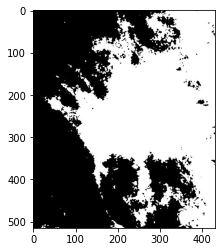

In [9]:
plt.imshow(im,cmap="gray")

In [10]:
gt = mpimg.imread(r'C:\Users\Asus\Desktop\PCD\Organized dataset\curated\P_00001\LEFT_CC\abnormality_0\GT_mask.jpg')
print(iou(im, gt_crop))
print(dice_coef(im,gt_crop))

IoU is 0.5226878452698795
0.5226878452698795
Dice coefficient is 0.567972428085509
0.567972428085509


In [36]:
print(im.shape)
print(gt_crop.shape)

(515, 431)
(515, 431)
